In [172]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

from sklearn.decomposition import NMF, PCA

from scipy.sparse import *
from scipy.io import mmread

# Import auryn tools
sys.path.append(os.path.expanduser("/usr/local/auryn/tools/python/"))
from auryntools import *

# Find low rank structure in spiking activity

In [173]:
num_mpi_ranks = 4 # the number of sims you used in parallel
datadir = os.path.expanduser("../data/sim_sleep") # Set this to your data path
prefix = "rf4"

number_neurons = 4096
number_stimuli = 6
time_range = 2400
bin_size = 100e-3

In [174]:
# Opens stim file
stimfile = np.loadtxt("%s/%s.0.stimtimes"%(datadir,prefix))
stimtimes = np.zeros(len(stimfile))
stimdata = np.zeros((len(stimfile),number_stimuli))
for i,row in enumerate(stimfile):
    t,a,s = row
    stimtimes[i] = t
    stimdata[i,int(s)] = a
    
# Opens spk output files
spkfiles  = ["%s/%s.%i.e.spk"%(datadir,prefix,i) for i in range(num_mpi_ranks)]
sfo = AurynBinarySpikeView(spkfiles)

print("Crunching file ...")
tm = sfo.t_max 
t_start = tm-time_range
t_stop  = tm
data = sfo.time_binned_spike_counts(t_start,t_stop,bin_size=bin_size, max_neuron_id=number_neurons)

Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Crunching file ...


### Get cell assemblies

In [175]:
# Constants
response_start = int(3 / bin_size)
response_end = int(3.5 / bin_size)
spike_threshold = 20 * (response_end - response_start) * bin_size  # Hz

stim_start_times = stimtimes[1::4]
stims = np.array([np.where(stim)[0][0] for stim in stimdata[1::4]]) 

# Function to get the associated time bin for the given float time. Ex: for t = 0.5, returns 50
def get_time_bin(t):
    return int(t / bin_size)

# Identify relevant time bins for each stimulus
response_bins = [
    np.array(range(
        get_time_bin(t) + response_start,
        min(get_time_bin(t) + response_end, get_time_bin(time_range)-1)
    ), dtype=int)
    for t in stim_start_times
]

stimulus_time_bins_list = [[] for _ in range(number_stimuli)]
for stim, bins in zip(stims, response_bins):
    stimulus_time_bins_list[stim].extend(bins)

# Determine which neurons respond to each stimulus
responding_neurons = []

for bins in stimulus_time_bins_list:
    # Sum up the spikes for each neuron in the identified bins
    spike_counts = np.sum(data[bins], axis=0)
    frequency = spike_counts / (len(bins) * bin_size)
    
    responding = np.where(frequency > spike_threshold)[0]
    responding_neurons.append(responding)

for i, neurons in enumerate(responding_neurons):
    print(f"Stimulus {i} has {len(neurons)} responding neurons")

Stimulus 0 has 109 responding neurons
Stimulus 1 has 483 responding neurons
Stimulus 2 has 777 responding neurons
Stimulus 3 has 811 responding neurons
Stimulus 4 has 606 responding neurons
Stimulus 5 has 655 responding neurons


### Network activation for each stimulus

Plotting ...


/tmp/ipykernel_7280/2229401982.py:32: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  markerline, stemlines, baseline = plt.stem(selected_times, spikes_stim[stim], basefmt=" ", linefmt=f'C{stim}', markerfmt=" ", use_line_collection=True)


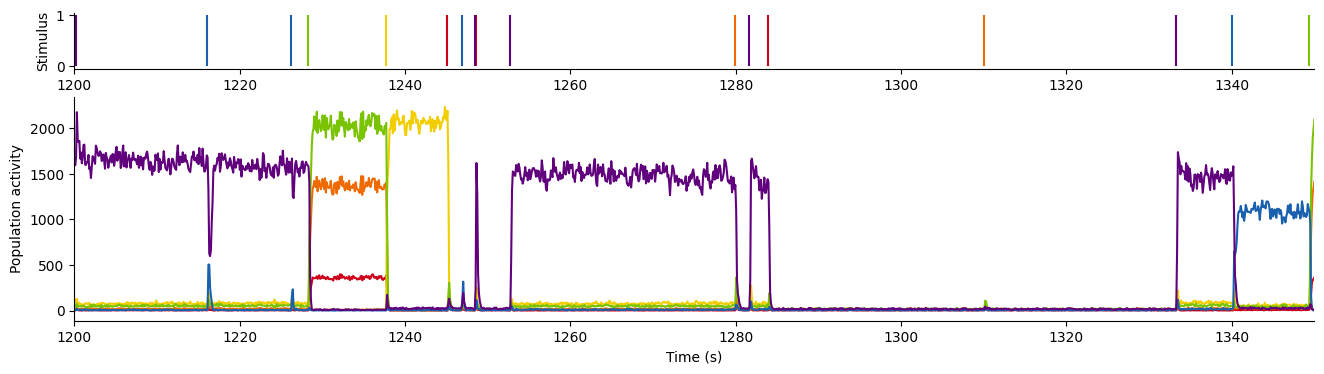

In [264]:
t_begin = 1200
t_end = 1350
t_begin_bin = int(t_begin // bin_size)
t_end_bin = int(t_end // bin_size)

time_mask = (stim_start_times > t_begin) & (stim_start_times < t_end)
selected_times = stim_start_times[time_mask]

single_stim_data = []
spikes_stim = []
ys = []
for stim in range(number_stimuli):
  curr_single_stim_data = data[:,responding_neurons[stim]][t_begin_bin:t_end_bin]
  curr_spikes_stim = np.where(stims == stim, 1, 0)[time_mask]
  curr_y = np.sum(curr_single_stim_data, axis=1)

  single_stim_data.append(curr_single_stim_data)
  spikes_stim.append(curr_spikes_stim)
  ys.append(curr_y) 

colors = ['#cd001a', '#ef6a00', '#f2cd00', '#79c300', '#1961ae', '#61007d']

print("Plotting ...")
time = np.linspace(t_begin, t_end, len(ys[0]))
gs = GridSpec(2,1,height_ratios=[1,4])
plt.figure(figsize=(16,4))
cmap = plt.get_cmap('Set1', number_stimuli)

ax = plt.subplot(gs[0])
# plt.plot(stimtimes, stimdata, color="gray")
for stim in range(number_stimuli):
  markerline, stemlines, baseline = plt.stem(selected_times, spikes_stim[stim], basefmt=" ", linefmt=f'C{stim}', markerfmt=" ", use_line_collection=True)
  plt.setp(stemlines, 'color', colors[stim])

plt.xlim((t_begin,t_end))
plt.xlabel("Time (s)")
plt.ylabel("Stimulus")
sns.despine()

ax = plt.subplot(gs[1])
for stim in range(number_stimuli):
  plt.plot(time, ys[stim], color=colors[stim])
plt.xlim((t_begin,t_end))
plt.xlabel("Time (s)")
plt.ylabel("Population activity")
sns.despine()

### Overlapping neurons in cell assembly

In [180]:
result_matrix = np.zeros((number_stimuli, number_stimuli), dtype=int)

for i in range(number_stimuli):
    for j in range(number_stimuli):
      result_matrix[i, j] = len(set(responding_neurons[i]) & set(responding_neurons[j]))
result_matrix


array([[109, 106,   0, 107,   1,   0],
       [106, 483,   0, 483,   1,   0],
       [  0,   0, 777,   1,   1,  19],
       [107, 483,   1, 811,   3,   8],
       [  1,   1,   1,   3, 606,   2],
       [  0,   0,  19,   8,   2, 655]])

### Times where there was a stimulus, but no response

In [217]:
for stim, bins in enumerate(stimulus_time_bins_list):
    spikes_stimbin_stimneuron = data[:,responding_neurons[stim]][stimulus_time_bins_list[stim]]

    spike_counts_per_stim = np.sum(spikes_stimbin_stimneuron, axis=1)
    frequency = spike_counts_per_stim / (len(responding_neurons[stim]))
    if stim == 5:
        print(frequency)
    

[2.72824427 2.85343511 2.76335878 2.64274809 2.74045802 2.84427481
 2.95877863 2.97862595 2.63206107 2.61374046 0.10687023 0.09770992
 0.09312977 0.10839695 0.10534351 0.10534351 0.10229008 0.10687023
 0.10534351 0.11145038 0.10076336 0.09770992 0.09160305 0.09465649
 0.11145038 2.87480916 2.89770992 3.00916031 2.98167939 3.10381679
 3.02442748 2.80916031 2.81068702 2.84732824 2.85648855 0.03358779
 0.03816794 0.03664122 0.03664122 0.04274809 2.74503817 2.77709924
 2.86259542 3.16793893 2.89160305 0.39389313 0.10992366 0.08396947
 0.10229008 0.08244275 0.02748092 0.0351145  0.03053435 0.02900763
 0.02748092 2.50687023 2.52671756 2.61679389 2.50992366 2.37709924
 0.03053435 0.02900763 0.0259542  0.0259542  0.03816794 2.24274809
 2.34961832 2.2519084  2.34198473 2.21526718 0.01984733 0.02290076
 0.02900763 0.01832061 0.03053435 2.2        1.97251908 2.12061069
 2.24885496 2.2870229  2.15419847 2.11145038 2.34503817 2.42900763
 2.07022901 2.38015267 2.31603053 2.31908397 2.3648855  2.2992